## データの読み込み

### 事前に実施すること
1. ファイルタブを開き、data ディレクトリを作成する。
1. 作成した data ディレクトリ直下に、学習データのイメージファイルとデータ一覧の data.csv を格納する。

サンプルデータとして下記を利用可能
https://~


In [23]:
import numpy as np
import pandas as pd
import os
from torch.utils.data import Dataset
import torch
import torchvision
from torch.utils.data import DataLoader
 
class Create_Datasets(Dataset):
     
    def __init__(self, dir_name, csv_file, data_transform):
        self.dir_name = dir_name
        self.df = pd.read_csv(self.dir_name + '/' + csv_file)
        self.data_transform = data_transform
 
    def __len__(self):
        return len(self.df)
     
    def __getitem__(self, i):
        file = self.df['id'][i]
        label = np.array(self.df['label'][i])
        image = Image.open(self.dir_name + '/' + file)
        image = self.data_transform(image)
 
        return image, label

In [24]:
data_transform = torchvision.transforms.Compose([torchvision.transforms.Grayscale(), torchvision.transforms.ToTensor()])

In [25]:
# 画像データは 100px
img_size = 100
# バッチサイズは 10 とする
batch_size = 10

In [26]:
dataset = Create_Datasets('data', 'data.csv', data_transform)

学習用データとテスト用データに分離

In [27]:
n_samples = len(dataset)
train_size = int(n_samples * 0.8)
test_size = n_samples - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## モデルの構築
今回は、`nn.Module`モジュールを継承したクラスとして、モデルを構築します。  
`.cuda()`により、モデルの計算はGPU上で行われるようになります。 

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(img_size*img_size, 1024)  # 全結合層
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 2)

    def forward(self, x):
        x = x.view(-1, img_size*img_size)  # バッチサイズ×入力の数
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.cuda()  # GPU対応
print(net)

Net(
  (fc1): Linear(in_features=10000, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=2, bias=True)
)


## 学習
モデルを訓練します。  
DataLoaderを使い、ミニバッチを取り出して訓練および評価を行います。  
1エポックの中で何度もミニバッチを使って訓練が行われるので、ミニバッチ法が実装されていることになります。  
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターでGPUを選択しましょう。

In [30]:
from PIL import Image
from torch import optim
import pandas as pd

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# SGD
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
for i in range(30):  # エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    loss_test = 0
    for j, (x, t) in enumerate(test_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()
        y = net(x)
        loss = loss_fnc(y, t)
        loss_test += loss.item()
    loss_test /= j+1
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 0.6932516120947324 Loss_Test: 0.66804153578622
Epoch: 1 Loss_Train: 0.6828039838717535 Loss_Test: 0.6659991911479405
Epoch: 2 Loss_Train: 0.6757392516502967 Loss_Test: 0.6531329921313694
Epoch: 3 Loss_Train: 0.6574415793785682 Loss_Test: 0.6654816355024066
Epoch: 4 Loss_Train: 0.6505853900542626 Loss_Test: 0.7427729623658317
Epoch: 5 Loss_Train: 0.6368728761489575 Loss_Test: 0.825063671384539
Epoch: 6 Loss_Train: 0.6583885390024918 Loss_Test: 0.661688472543444
Epoch: 7 Loss_Train: 0.6279729535946479 Loss_Test: 0.6302431140627179
Epoch: 8 Loss_Train: 0.63155214373882 Loss_Test: 0.6548270157405308
Epoch: 9 Loss_Train: 0.6315701546577307 Loss_Test: 0.649156425680433
Epoch: 10 Loss_Train: 0.6186300218105316 Loss_Test: 0.8125022564615522
Epoch: 11 Loss_Train: 0.6201180242575132 Loss_Test: 0.6168772833687919
Epoch: 12 Loss_Train: 0.5968214158828442 Loss_Test: 0.6589383142335075
Epoch: 13 Loss_Train: 0.5774289083022338 Loss_Test: 0.6943328976631165
Epoch: 14 Loss_Train: 0

## 誤差の推移
訓練データ、テストデータで誤差の推移をグラフ表示します。  

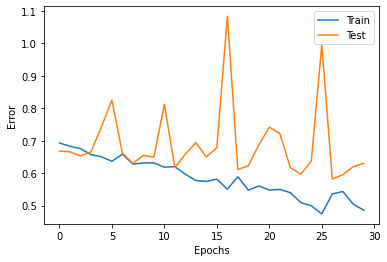

In [31]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 正解率
モデルの性能を把握するため、テストデータ使い正解率を測定します。

In [32]:
correct = 0
total = 0
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    x = x.view(-1, img_size*img_size)
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 65.625%
